In [1]:
from pyspark.sql import SparkSession

import pyspark.sql.functions as spf

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = SparkSession.builder.appName("anokhin").getOrCreate()
spark

## Model Based Collaborative filtering

### Собираем данные на Spark и сохраняем как pandas dataframe

In [3]:
data = (
    spark.read.json("/user/anokhin/week03/*/data.json")
        .filter(spf.col("time") > 0.8)
        .select("user", "track", "time")
        .groupBy("user", "track")
        .agg(
            spf.avg("time").alias("time")
        )
        .withColumn("test", spf.rand() > 0.7)
)

data.limit(10).show()

+----+-----+----+-----+
|user|track|time| test|
+----+-----+----+-----+
|8919|38622|0.99| true|
|2803|12040| 1.0| true|
|6263|19518| 1.0|false|
|5109| 7098| 1.0|false|
|  30| 1046| 1.0| true|
|3300| 4460| 1.0|false|
|9626|29437|0.91| true|
|2910|  559| 1.0|false|
|9924|18350| 1.0|false|
|1925|  511| 1.0|false|
+----+-----+----+-----+



In [4]:
data.toPandas().to_json("/home/anokhin/data/week04.json", orient="records", lines=True)

### Обучаем ALS на Spark и сохраняем рекомендации

In [5]:
als = ALS(
    rank=50,
    maxIter=25, 
    regParam=0.1, 
    userCol="user", 
    itemCol="track", 
    ratingCol="time",
    coldStartStrategy="drop",
).fit(data.filter(spf.col("test") == False))

In [6]:
predictions = als.transform(data.filter(spf.col("test") == True))

evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="time",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.10660422882594421


In [7]:
(
    als
        .recommendForAllUsers(100)
        .select(
            spf.col("user"),
            spf.col("recommendations.track").alias("tracks")
        )
).toPandas().to_json("/home/anokhin/data/recomendations_als.json", orient="records", lines=True)

### Train LightFM

In [45]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.special as sp

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [3]:
data = pd.read_json("/Users/n.anokhin/Desktop/week04.json", lines=True)

data.head()

,user,track,time,test
0,2697,3221,1.00,True
1,9080,10943,0.84,False
2,7865,3085,1.00,False
3,194,5292,1.00,False
4,108,743,1.00,False


In [6]:
user_counts = data.loc[~data["test"], "user"].value_counts()
users = set(user_counts[user_counts >= 5].index.values)

len(users)

7534

In [8]:
track_counts = data.loc[~data["test"], "track"].value_counts()
tracks = set(track_counts[track_counts >= 5].index.values)

len(tracks)

3231

In [10]:
train_data = data[~data["test"] & data["user"].isin(users) & data["track"].isin(tracks)]
test_data = data[data["test"] & data["user"].isin(users) & data["track"].isin(tracks)]

len(train_data), len(test_data)

(31273, 10254)

In [11]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [12]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [13]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=user_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=1, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]


In [15]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

best_params

[I 2023-10-10 23:23:12,647] A new study created in memory with name: no-name-0d74e7db-1ee8-463a-a103-1848cea36c26
[I 2023-10-10 23:23:13,417] Trial 0 finished with value: 0.008358265273272991 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 100, 'user_alpha': 0.0, 'item_alpha': 0.001}. Best is trial 0 with value: 0.008358265273272991.
[I 2023-10-10 23:23:14,004] Trial 1 finished with value: 0.008881825022399426 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 100, 'user_alpha': 0.0, 'item_alpha': 0.01}. Best is trial 1 with value: 0.008881825022399426.
[I 2023-10-10 23:23:14,744] Trial 2 finished with value: 0.008339566178619862 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.001, 'max_sampled': 50, 'user_alpha': 0.001, 'item_alpha': 0.001}. Best is trial 1 with value: 0.008881825022399426.
[I 2023-10-10 23:23:15,456] Trial 3 finished with value: 0.008227374404668808 and param

{'loss': 'warp',
 'no_components': 10,
 'learning_rate': 0.01,
 'max_sampled': 100,
 'user_alpha': 0.0,
 'item_alpha': 0.01}

In [16]:
best_params = {'loss': 'warp',
 'no_components': 50,
 'learning_rate': 0.01,
 'max_sampled': 100,
 'user_alpha': 0.0,
 'item_alpha': 0.01}

In [17]:
model, precisions_at = fit_model(
    epochs=100,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.008096485398709774 +/- 0.0008096353854552563
1:	0.008246073499321938 +/- 0.0008217346398828953
2:	0.008433058857917786 +/- 0.0008349782024998294
3:	0.008788332343101501 +/- 0.0008522781634206281
4:	0.009723260998725891 +/- 0.0009078017220636788
5:	0.010882573202252388 +/- 0.0009839465909051652
6:	0.011686611920595169 +/- 0.0010183622013500747
7:	0.012490651570260525 +/- 0.0010639134750582493
8:	0.013556470163166523 +/- 0.0010938929318378087
9:	0.014921466819941998 +/- 0.0011444352902746002
10:	0.016529543325304985 +/- 0.0012066898092685224
11:	0.01780104637145996 +/- 0.0012550701530878283
12:	0.018904265016317368 +/- 0.001294766095344889
13:	0.019951384514570236 +/- 0.001330707416760972
14:	0.020979806780815125 +/- 0.0013668076892840576
15:	0.021970830857753754 +/- 0.0013912769741457373
16:	0.022606581449508667 +/- 0.0014070444846483003
17:	0.023560209199786186 +/- 0.0014351469804601816
18:	0.024289453402161598 +/- 0.0014492771547794927
19:	0.025411367416381836 +/- 0.0014741742697

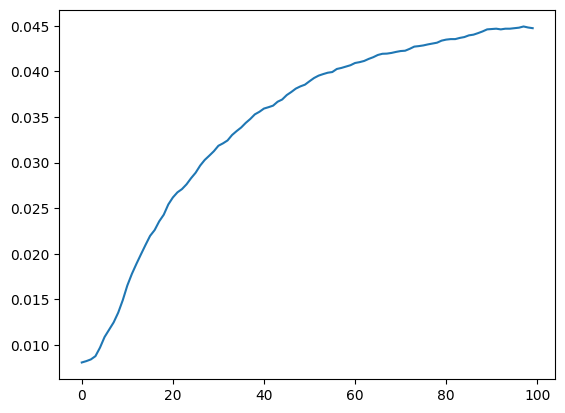

In [19]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

In [47]:
predictions = model.predict(
    test_data["user"].map(dataset.mapping()[0]).values,
    test_data["track"].map(dataset.mapping()[2]).values,
)

rmse = np.sqrt(((predictions - test_data["time"].values) * (predictions - test_data["time"].values)).mean())
rmse # Q: ???

1.0315118853116914

## Save track embeddings

In [22]:
BOTIFY_DATA_DIR = "/Users/n.anokhin/Projects/recsys-course/botify/data/"

In [23]:
biases, embeddings = model.get_item_representations()

In [24]:
track_meta = pd.read_json(BOTIFY_DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [25]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [28]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir="/Users/n.anokhin/Desktop/tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [29]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [30]:
predictions = model.predict(1, np.arange(dataset.item_features_shape()[0]), num_threads=30)
predictions

array([-0.91547966, -0.3986804 , -1.2493805 , ..., -0.10818789,
        1.7828356 , -0.3263796 ], dtype=float32)

In [32]:
with open(BOTIFY_DATA_DIR + "recommendations_lfm.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": top.tolist()
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7534/7534 [00:04<00:00, 1867.89it/s]
